<a href="https://colab.research.google.com/github/cathay/cnn/blob/master/driver_action_detection_load_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import zipfile
import random
import tensorflow as tf
from shutil import copyfile
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

#Import Google drive functions
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def get_im_cv2(path, w, h):
  img = cv2.imread(path)
  resized = cv2.resize(img, (w,h), cv2.INTER_LINEAR) 
  return resized

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import shutil
from tensorflow import keras
DRIVE_PATH = '/content/drive/My Drive/colab/'
shutil.copyfile(DRIVE_PATH + 'eroad_action_detection_resnet_10_epoch.h5', 'eroad_action_detection_resnet_10_epoch.h5')
model = keras.models.load_model('eroad_action_detection_resnet_10_epoch.h5')


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               5

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg
[0.02177476 0.95270896 0.01595353 0.00956273]
1
Classified: drinking


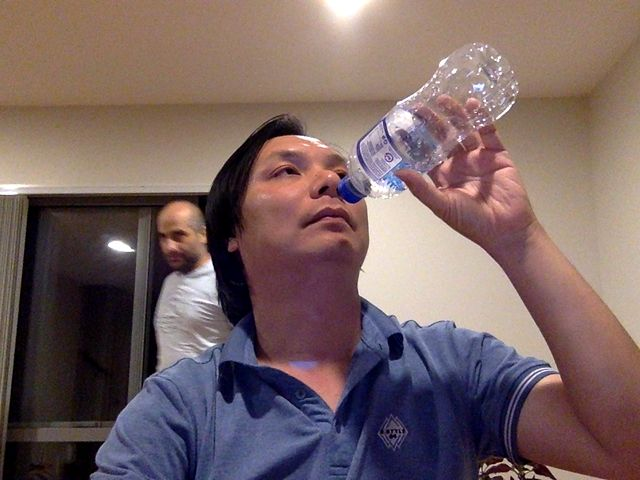

In [22]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
label_map = {
    0: 'normal',
    1: 'drinking',
    2: 'phone_left',
    3: 'phone_right'
}

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  img = get_im_cv2(filename, IMAGE_WIDTH, IMAGE_HEIGHT)

  x_predict=[]
  x_predict.append(img)
  x_predict = np.array(x_predict, dtype=np.uint8)
  prediction = model.predict(x_predict);

  label = np.argmax(prediction)

  print(*prediction) 
  print(label)
  print("Classified: %s" % (label_map.get(label)))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [0]:
import shutil
DRIVE_PATH = '/content/drive/My Drive/colab/'
TEST_FILE = 'predict0.zip'
TEST_DATA_PARENT_FOLDER = 'tmp/test'

shutil.copyfile(DRIVE_PATH + TEST_FILE, TEST_FILE)

if os.path.exists(TEST_DATA_PARENT_FOLDER):
  shutil.rmtree(TEST_DATA_PARENT_FOLDER)

zip_ref = zipfile.ZipFile(TEST_FILE, 'r')
zip_ref.extractall(TEST_DATA_PARENT_FOLDER)
zip_ref.close()

In [0]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

TEST_DATA_FOLDER = 'tmp/test/predict0/c0'
files = []
for file in os.listdir(TEST_DATA_FOLDER):
    if file.endswith(".jpg"):
        files.append(file)

test_data = pd.DataFrame({'filename': files})
#test_data_frame = test_data.sample(20, axis=None)
#test_data['path'] = test_data['filename'].map(lambda file: TEST_DATA_FOLDER + "/" + file)
test_data['X'] = test_data['filename'].map(lambda file: get_im_cv2(TEST_DATA_FOLDER + "/" + file, IMAGE_WIDTH, IMAGE_HEIGHT))

x_perf=[]
for item in test_data['X']:
  x_perf.append(item)

x_perf = np.array(x_perf, dtype=np.uint8)
predict_df = model.predict(x_perf)

In [9]:
label_map = {
    0: "normal driving",
    1: "texting - right",
    2: "talking on the phone - right",
    3: "texting - left",
    4: "talking on the phone - left",
    5: "operating the radio",
    6: "drinking",
    7: "reaching behind",
    8: "hair and makeup",
    9: "talking to passenger"
}

test_data['category'] = np.argmax(predict_df, axis=1)
test_data['action'] = test_data['category'].map(lambda x: label_map.get(x))

print(len(files))
print(test_data[test_data['category'] ==0].shape)
print(test_data[test_data['category'] !=0].shape)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
 #   print(test_data[test_data['category'] !=0].head())

791
(4, 4)
(787, 4)


In [10]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

sample_test = test_data[test_data['category'] !=0][20:30]
plt.figure(figsize=(12, 24))
index=0
for _, row in sample_test.iterrows():
    filename = row['filename']
    category = row['action']
    index=index+1
    img = load_img(TEST_DIRECTORY+"/c0/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

Using TensorFlow backend.


NameError: ignored

<Figure size 864x1728 with 0 Axes>

In [0]:
#Copy prediction file to G-drive
import shutil
CATEGORY_PATH='tmp/predict' + str(index)
if os.path.exists(CATEGORY_PATH):
  shutil.rmtree(CATEGORY_PATH)
#print(test_data.head())
if not os.path.exists(CATEGORY_PATH):
  os.mkdir(CATEGORY_PATH)
  for i in range(10):
    os.mkdir("%s/c%s"% (CATEGORY_PATH,str(i)))

test_data['category'] = np.argmax(predict_df, axis=1)
for _, row in test_data.iterrows():
  #print(row['category'])
  #print(str(row['category']))
  shutil.copyfile(TEST_DIRECTORY + "/" + row['filename'], CATEGORY_PATH + "/" + 'c' + str(row['category']) + "/" + row['filename'])

ZIP_FILE_NAME='predict' + str(index)
shutil.make_archive(ZIP_FILE_NAME, 'zip', CATEGORY_PATH)
shutil.copyfile(ZIP_FILE_NAME +'.zip','/content/drive/My Drive/colab/' + ZIP_FILE_NAME + '.zip')